In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6rh3n9un because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
DEV_LOG = "../experiments/graphunet_hyperparam_tuning/logs_training/logging/result.pkl"

with open(DEV_LOG, 'rb') as file:
    TMP_FILE = pickle.load(file)

LOG_DICT = {}

for key, metrics in TMP_FILE.items():
    tmp_dict = {}

    key_dict = eval(key)
    # Remove unnecessary fields
    key_dict.pop('activation', None)
    key_dict.pop('in_channels', None)
    key_dict.pop('out_channels', None)
    key_dict.pop('nodes_per_graph', None)
    # Convert the dictionary back to a string to use as a key
    processed_key = str(key_dict)
    
    tmp_dict['accuracy'] = float(metrics.get('accuracy', -1))
    tmp_dict['precision'] = float(metrics.get('precision', -1))
    tmp_dict['recall'] = float(metrics.get('recall', -1))
    tmp_dict['F1 score'] = float(metrics.get('F1 score', -1))
    
    # Add the processed key and metrics to the new dictionary
    LOG_DICT[processed_key] = tmp_dict

# Example usage: print the processed LOG_DICT
#print(LOG_DICT)

## Visualization of the experiment results

Parameters to inspect: ['epochs', 'optimizer_cls', 'optimizer_args', 'optimizer_cls_version']
Optimizers: ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'NAdam', 'RMSprop', 'SGD']
version __, args: {'lr': 0.01, 'alpha': 0.99, 'eps': 1e-08, 'weight_decay': 0, 'momentum': 0, 'centered': False}
version v1, args: {'lr': 0.001, 'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


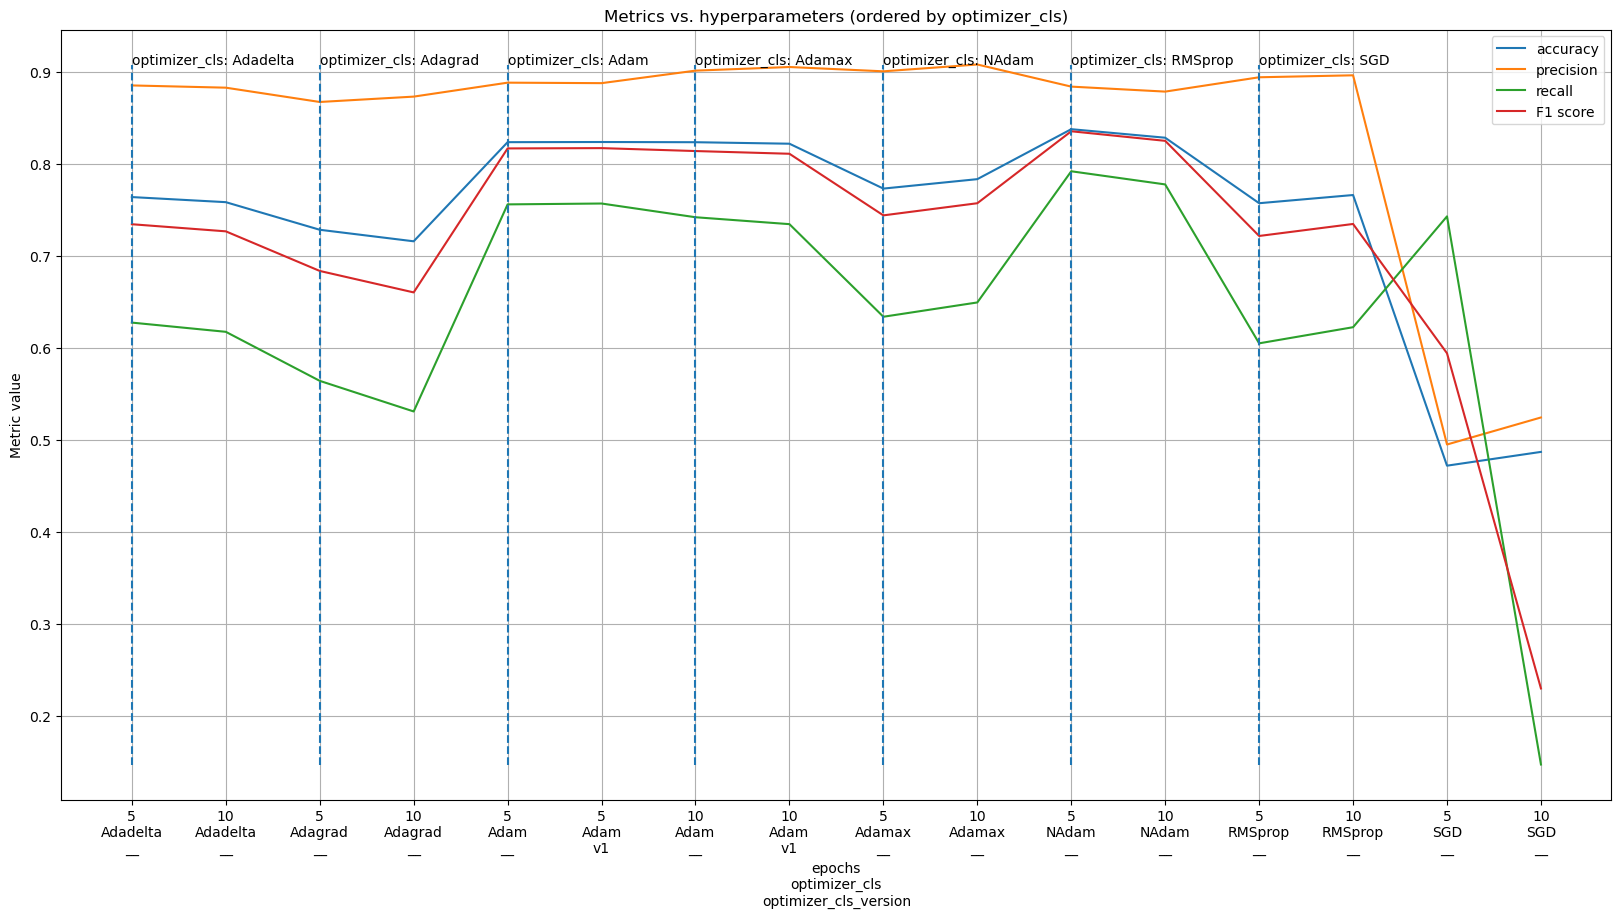

In [3]:
import json
plt.figure(figsize=(20, 10))

# get unique parameter values and sort them for better visualizations
unique_params = {}
for params, _ in LOG_DICT.items():
    params = eval(params)
    for key, value in params.items():
        if key not in unique_params:
            unique_params[key] = [value]
        elif key in unique_params and value not in unique_params[key]:
            unique_params[key].append(value)

for key, values in unique_params.items():
    if all(isinstance(v, dict) for v in values):  # Check if all elements in the list are dictionaries
        # Sort dictionaries by serialized JSON strings
        unique_params[key].sort(key=lambda x: json.dumps(x, sort_keys=True))
    else:
        # Sort non-dictionary lists normally
        values.sort()

# add to the X axis all the parameters that were inspected within the tuning process
PARAM_X_AXIS = []
for key,value in unique_params.items():
    if len(value) > 1:
        PARAM_X_AXIS.append(key)

print("Parameters to inspect:", PARAM_X_AXIS)

# if optimizer_args is in there, remove it, as it can be too much text to put in the plot
if 'optimizer_args' in PARAM_X_AXIS:
    PARAM_X_AXIS.remove('optimizer_args')
    
    print("Optimizers:", unique_params['optimizer_cls'])
    for args,version in zip(unique_params['optimizer_args'], unique_params['optimizer_cls_version']):
        print(f'version {version}, args:', args)

# decide over which parameter you want to sort the results in the plot (useful to see trends)
PARAM_TO_VIZ = PARAM_X_AXIS[1]


hyperparams = []
accuracy = []
precision = []
recall = []
F1_score = []

# collect the metrics for every unique value of the parameter I want to understand
for value in unique_params[PARAM_TO_VIZ]:
    for key, metrics in LOG_DICT.items():
        hp = eval(key)
        if hp[PARAM_TO_VIZ] == value:
            key = '\n'.join(f"{hp[element]}" for element in PARAM_X_AXIS)
            hyperparams.append(key)
            accuracy.append(metrics['accuracy'])
            precision.append(metrics['precision'])
            recall.append(metrics['recall'])
            F1_score.append(metrics['F1 score'])

x_indices = np.arange(len(hyperparams))

# plot each performance metric
plt.plot(x_indices, accuracy, label='accuracy')
plt.plot(x_indices, precision, label='precision')
plt.plot(x_indices, recall, label='recall')
plt.plot(x_indices, F1_score, label='F1 score')

# plot a line to divide each section of the 'to_visualize' parameter values
n_lines = len(unique_params[PARAM_TO_VIZ])
x_lines = []
for i in range(n_lines):
    x = i*(len(x_indices)//n_lines)
    ymin = min(min(accuracy, precision, recall, F1_score))
    ymax = max(max(accuracy, precision, recall, F1_score))
    plt.vlines(x=x, ymin=ymin, ymax=ymax, linestyle='--')
    plt.text(x=x, y=ymax, s=f'{PARAM_TO_VIZ}: {unique_params[PARAM_TO_VIZ][i]}')


# mark this position in the plot to get better insight
#index = 50
#plt.text(x=index, y=0.5, s=f'{hyperparams[index]}')

# prepare and set x-axis values and labels
plt.xticks(x_indices, hyperparams)
plt.xlabel('\n'.join(PARAM_X_AXIS))

plt.ylabel('Metric value')
plt.title(f'Metrics vs. hyperparameters (ordered by {PARAM_TO_VIZ})')
plt.legend()  # Add legend to show labels

plt.grid(True)
plt.show()